# Mean squared error

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.stats import shapiro, probplot
from statsmodels.graphics.tsaplots import plot_acf

Best hyperparameters: {'svr__gamma': 0.01, 'svr__epsilon': 1, 'svr__C': 1000, 'select__k': 3}
Mean squared error: -0.06907193765763278
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean squared error: 1224.5906465067344
Test set mean absolute error: 30.489644737244586
Test set R-squared score: -0.14589555338572024
95% confidence interval for test set predictions: [38.43981648677175, 56.60936384109711]
Shapiro-Wilk test for normality of residuals:
Statistic: 0.967003583908081
p-value: 0.09868869930505753
The residuals are likely no

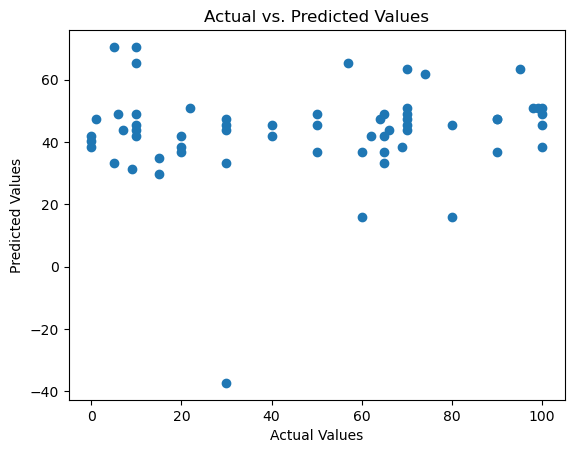

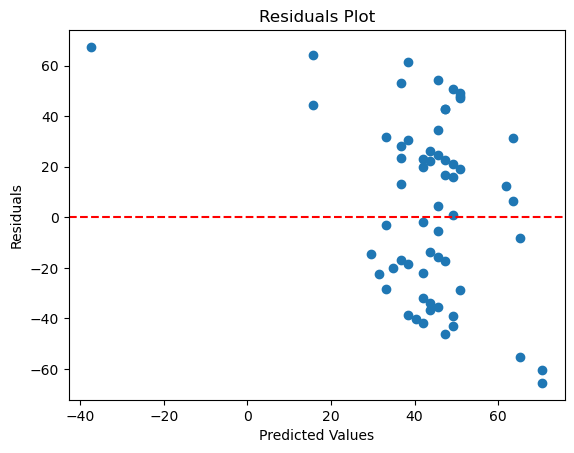

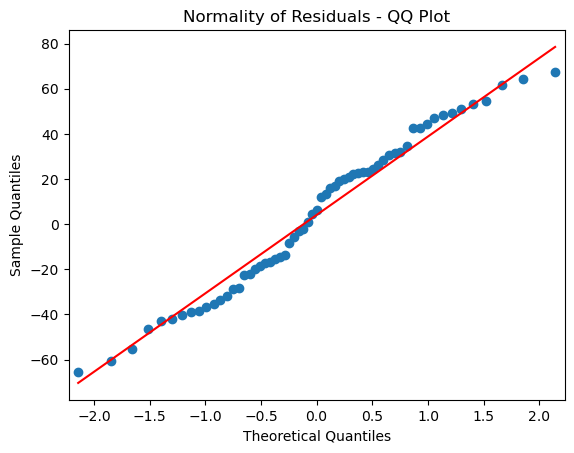

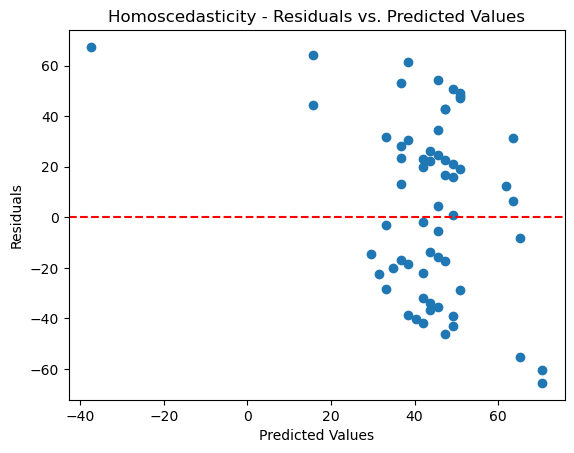

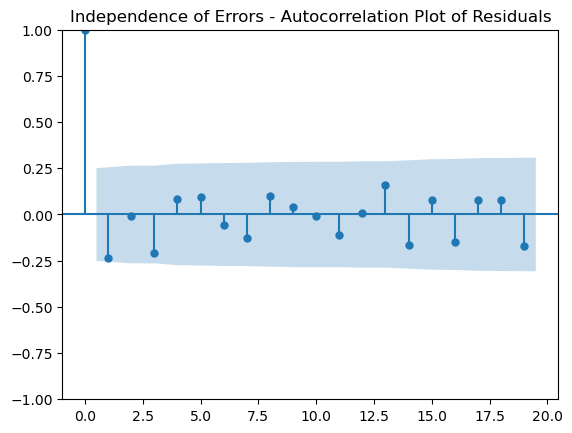

95% confidence interval for MSE: [ 922.09270806 1517.27415607]
95% confidence interval for MAE: [26.30201374 34.63477713]
95% confidence interval for R2: [-0.43619861  0.04308285]


In [6]:
# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level','programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(f_regression)),
    ('svr', SVR())
])

# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42)
randomized_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding MSE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean squared error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean squared error:", mse)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mse)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# # Plot the residuals
residuals = y_test - y_pred

# Check if the residuals are normally distributed
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")

# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residuals plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Normality of residuals - QQ plot
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals - QQ Plot')
plt.show()

# Homoscedasticity - Residuals vs. Predicted Values plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity - Residuals vs. Predicted Values')
plt.show()

# Independence of errors - Autocorrelation plot of residuals

plot_acf(residuals, lags=19)
plt.title('Independence of Errors - Autocorrelation Plot of Residuals')
plt.show()


from sklearn.utils import resample

# Define function to calculate R-squared, MSE, and MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Perform bootstrapping to calculate confidence intervals
n_bootstraps = 1000 # Number of bootstraps
mse_scores = []
mae_scores = []
r2_scores = []
for i in range(n_bootstraps):
    # Bootstrap the test set
    X_test_boot, y_test_boot = resample(X_test, y_test, random_state=i)
    
    # Make predictions on bootstrapped test set
    y_pred_boot = randomized_search.predict(X_test_boot)
    
    # Calculate metrics on bootstrapped test set
    mse_boot, mae_boot, r2_boot = calculate_metrics(y_test_boot, y_pred_boot)
    
    # Append scores to lists
    mse_scores.append(mse_boot)
    mae_scores.append(mae_boot)
    r2_scores.append(r2_boot)

# Calculate confidence intervals
alpha = 0.05 # Significance level
mse_ci = np.percentile(mse_scores, q=[alpha/2*100, (1-alpha/2)*100])
mae_ci = np.percentile(mae_scores, q=[alpha/2*100, (1-alpha/2)*100])
r2_ci = np.percentile(r2_scores, q=[alpha/2*100, (1-alpha/2)*100])

# Print confidence intervals
print("95% confidence interval for MSE:", mse_ci)
print("95% confidence interval for MAE:", mae_ci)
print("95% confidence interval for R2:", r2_ci)

# mean_absolute_error

Best hyperparameters: {'svr__gamma': 0.01, 'svr__epsilon': 1, 'svr__C': 1000, 'select__k': 3}
Mean absolute error: 24.071806058886274
course_ML: False, p-value: 0.4232931608582372
course_retrieval: False, p-value: 0.47108119845709884
course_statistics: True, p-value: 0.005896936252828015
course_databases: False, p-value: 0.41943153221865626
gender: False, p-value: 0.4958642029820335
ChatGPT: False, p-value: 0.10259798368659791
age: False, p-value: 0.7650863729065188
students_in_room: False, p-value: 0.09706370476471446
prev_answer_stand: True, p-value: 0.010789003246906658
sports_per_week: True, p-value: 2.9824427791548697e-05
Test set mean absolute error: 30.489644737244586
Test set R-squared score: -0.14589555338572024
95% confidence interval for test set predictions: [46.09109964283543, 48.95808068503342]
Shapiro-Wilk test for normality of residuals:
Statistic: 0.967003583908081
p-value: 0.09868869930505753
The residuals are likely normally distributed.


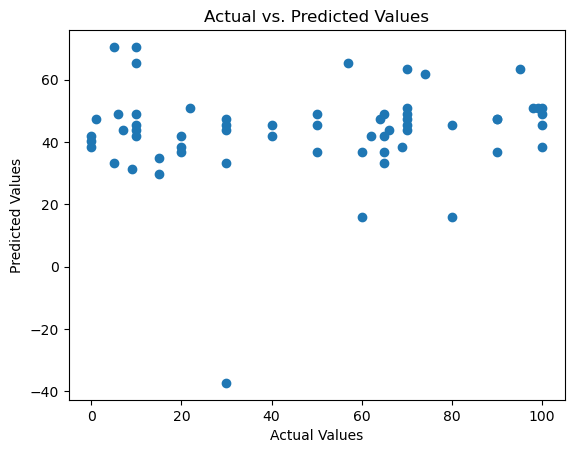

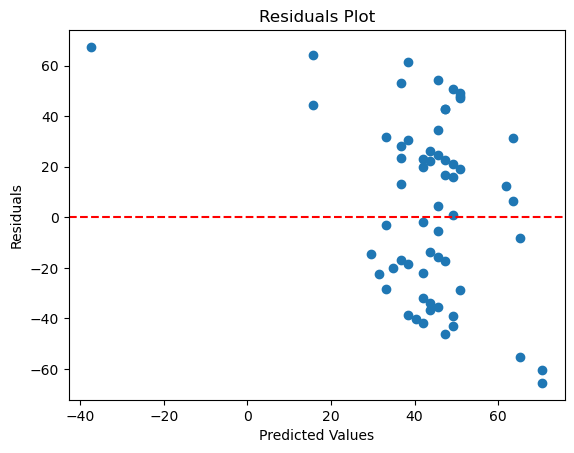

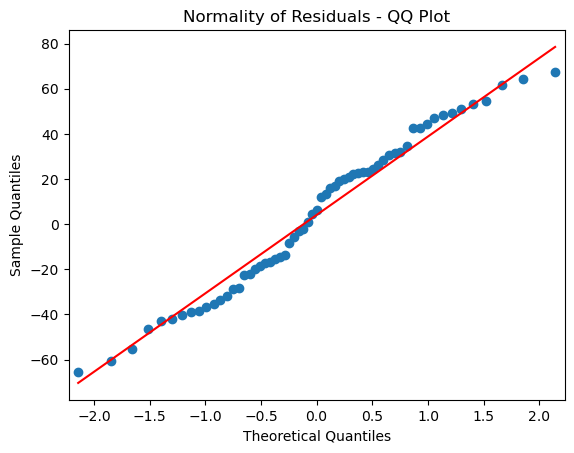

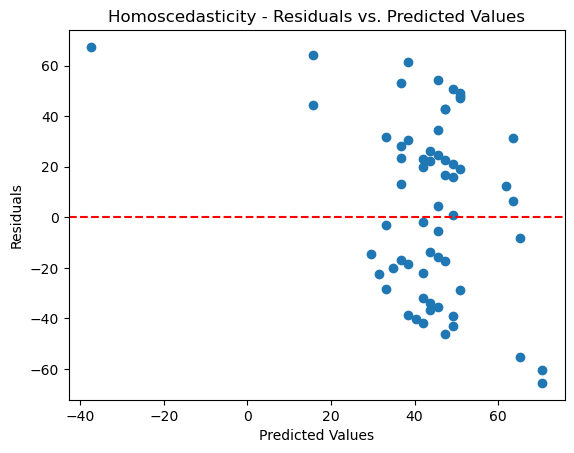

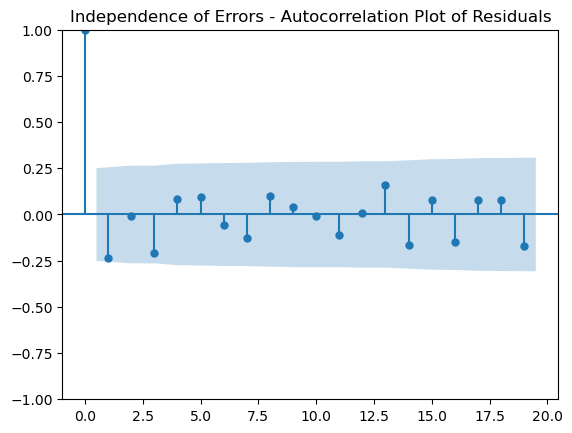

95% confidence interval for MSE: [ 922.09270806 1517.27415607]
95% confidence interval for MAE: [26.30201374 34.63477713]
95% confidence interval for R2: [-0.43619861  0.04308285]


In [7]:
# Load the dataset
data = pd.read_csv('new_data_fill_missing_linear&mode.csv')

# Separate target variable and feature variables
target = data['stress_level']
data = data.drop(['stress_level','programme',"Tijdstempel",'random_number','good_day_(1)',
                  'good_day_(2)','birthday','bed_time'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the hyperparameters to be tuned
param_distributions = {
        'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__epsilon': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
            'svr__gamma': [0.0001, 0.0005,  0.001, 0.005,  0.01, 0.05, 1, 5, 10],
     'select__k': [2, 3, 4]  # select the best 2, 3, or 4 features
}

# Create a pipeline to select the best features and train the SVR model
pipeline = Pipeline([
    ('select', SelectKBest(f_regression)),
    ('svr', SVR())
])


# Perform a randomized search to find the best hyperparameters
randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, random_state=42, scoring='neg_mean_absolute_error')
randomized_search.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding MAE score
print("Best hyperparameters:", randomized_search.best_params_)
print("Mean absolute error:", -randomized_search.best_score_)

# Print the selected features and their p-values
selected_features = randomized_search.best_estimator_.named_steps['select'].get_support()
p_values = randomized_search.best_estimator_.named_steps['select'].pvalues_
feature_names = data.columns
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {selected_features[i]}, p-value: {p_values[i]}")

# Evaluate the performance on the test set using the best hyperparameters
y_pred = randomized_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test set mean absolute error:", mae)
print("Test set R-squared score:", r2)

# Calculate the confidence interval for the test set
n = len(y_test)
k = randomized_search.best_estimator_.named_steps['select'].k
y_mean = np.mean(y_test)
t_value = 1.96 # t-value for 95% confidence interval
y_pred_std = np.sqrt(mae)
ci_half_width = t_value * y_pred_std / np.sqrt(n-k-1)
ci_lower = y_mean - ci_half_width
ci_upper = y_mean + ci_half_width
print(f"95% confidence interval for test set predictions: [{ci_lower}, {ci_upper}]")

# # Plot the residuals
residuals = y_test - y_pred

# Check if the residuals are normally distributed
stat, p = shapiro(residuals)
print("Shapiro-Wilk test for normality of residuals:")
print("Statistic:", stat)
print("p-value:", p)
if p > 0.05:
    print("The residuals are likely normally distributed.")
else:
    print("The residuals are not normally distributed.")

# Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residuals plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Normality of residuals - QQ plot
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals - QQ Plot')
plt.show()

# Homoscedasticity - Residuals vs. Predicted Values plot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity - Residuals vs. Predicted Values')
plt.show()

# Independence of errors - Autocorrelation plot of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=19)
plt.title('Independence of Errors - Autocorrelation Plot of Residuals')
plt.show()

from sklearn.utils import resample

# Define function to calculate R-squared, MSE, and MAE
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Perform bootstrapping to calculate confidence intervals
n_bootstraps = 1000 # Number of bootstraps
mse_scores = []
mae_scores = []
r2_scores = []
for i in range(n_bootstraps):
    # Bootstrap the test set
    X_test_boot, y_test_boot = resample(X_test, y_test, random_state=i)
    
    # Make predictions on bootstrapped test set
    y_pred_boot = randomized_search.predict(X_test_boot)
    
    # Calculate metrics on bootstrapped test set
    mse_boot, mae_boot, r2_boot = calculate_metrics(y_test_boot, y_pred_boot)
    
    # Append scores to lists
    mse_scores.append(mse_boot)
    mae_scores.append(mae_boot)
    r2_scores.append(r2_boot)

# Calculate confidence intervals
alpha = 0.05 # Significance level
mse_ci = np.percentile(mse_scores, q=[alpha/2*100, (1-alpha/2)*100])
mae_ci = np.percentile(mae_scores, q=[alpha/2*100, (1-alpha/2)*100])
r2_ci = np.percentile(r2_scores, q=[alpha/2*100, (1-alpha/2)*100])

# Print confidence intervals
print("95% confidence interval for MSE:", mse_ci)
print("95% confidence interval for MAE:", mae_ci)
print("95% confidence interval for R2:", r2_ci)